# EE219 Project 4: Regression Analysis

### Team members:
* **Yin Fei** 404284074

* **Yichen Wu** 504294181

* **Siyuan Chen** 405024391

* **Ruchen Zhen** 205036408

### Required Packages:
python 3.6  
numpy v1.14.0  
scikit-learn v0.19.1  
scipy v1.0.0  
matplotlib v2.1.2  
pandas v0.22.0   


### Part 1) Load the dataset.

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [83]:
df = pd.read_csv('data/network_backup_dataset.csv', header=0)
df_index = ['Week #', 'Day of Week', 'Backup Start Time - Hour of Day', \
            'Work-Flow-ID', 'File Name', 'Size of Backup (GB)', \
            'Backup Time (hour)', 'day number']
map_day = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, \
           'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

#### create day number column

In [84]:
day_number = []
for weeknum, dayofweek in np.array(df[df_index[:2]]):
    day_number.append( (weeknum-1)*7 + map_day[dayofweek] )
df['day number'] = day_number

**(a) For a twenty-day period (X-axis unit is day number) plot the backup sizes for
all workflows (color coded on the Y-axis)**

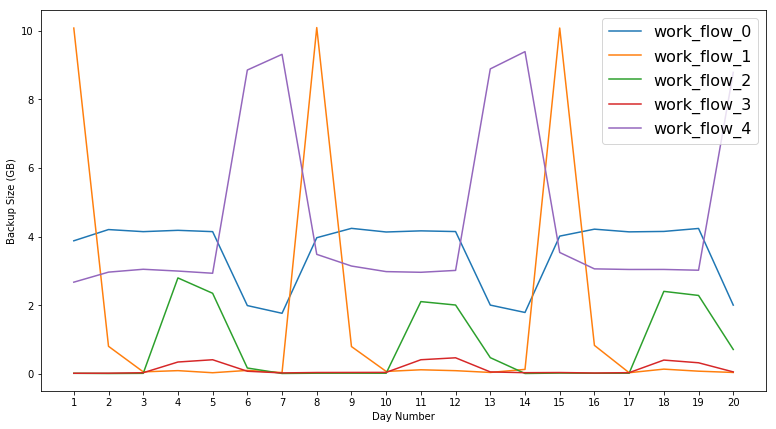

In [85]:
df_part1a = df.loc[ df['day number'] <= 20 ]
workflowlist = np.unique(df_part1a['Work-Flow-ID'])

plt.figure( figsize=(13, 7) )
for i in range(len(workflowlist)):
    temp = df_part1a.loc[ df_part1a['Work-Flow-ID'] == workflowlist[i] ]
    tempbackup = []
    for j in range(1,21):
        tempbackup.append( \
            sum( (temp.loc[temp['day number']==j])['Size of Backup (GB)']) )
    plt.plot(range(1,21), tempbackup, label=workflowlist[i])

plt.legend(loc='upper right', prop={'size': 16})
plt.ylabel('Backup Size (GB)')
plt.xlabel('Day Number')
plt.xticks(range(1,21))
plt.show()

**(b) Do the same plot for the first 105-day period.**

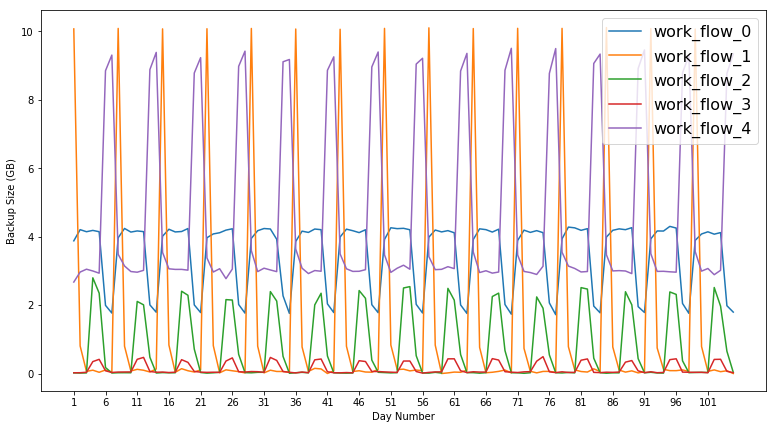

In [86]:
df_part1b = df.loc[ df['day number'] <= 105 ]
workflowlist = np.unique(df_part1b['Work-Flow-ID'])

plt.figure( figsize=(13, 7) )
for i in range(len(workflowlist)):
    temp = df_part1b.loc[ df_part1b['Work-Flow-ID'] == workflowlist[i] ]
    tempbackup = []
    for j in range(1,106):
        tempbackup.append( \
            sum( (temp.loc[temp['day number']==j])['Size of Backup (GB)']) )
    plt.plot(range(1,106), tempbackup, label=workflowlist[i])

plt.legend(loc='upper right', prop={'size': 16})
plt.ylabel('Backup Size (GB)')
plt.xlabel('Day Number')
plt.xticks(range(1,106,5))
plt.show()


### Part 2) Predict the backup size of a file given the other attributes.

#### a) Fit a linear regression model.

In [87]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

In [88]:
df.tail(3)

Week # Day of Week  Backup Start Time - Hour of Day Work-Flow-ID  \
18585      15      Sunday                               21  work_flow_4   
18586      15      Sunday                               21  work_flow_4   
18587      15      Sunday                               21  work_flow_4   

      File Name  Size of Backup (GB)  Backup Time (hour)  day number  
18585   File_26             0.198572                   2         105  
18586   File_25             0.199570                   2         105  
18587   File_24             0.201201                   2         105

First convert each categorical feature into one dimensional numerical values
using scalar encoding.

In [151]:
week_number = df[df_index[0]].tolist()

day_of_week = []
for day in df[df_index[1]].tolist():
    day_of_week.append(map_day[day])
    
hour_of_day = df[df_index[2]].tolist()

workflowid = df[df_index[3]].tolist()
for i in range(len(workflowid)):
    workflowid[i] = int(workflowid[i].replace('work_flow_',''))

filename = df[df_index[4]].tolist()
for i in range(len(filename)):
    filename[i] = int(filename[i].replace('File_',''))
    
sizeofbackup = df[df_index[5]].tolist()

In [152]:
featurematrix = np.stack(\
        (week_number, day_of_week, hour_of_day, \
         workflowid, filename, sizeofbackup), axis=-1)

y = np.float64(df['Backup Time (hour)'].tolist()) #'Backup Time (hour)'

In [160]:
from sklearn.model_selection import cross_validate
def reportandplot(clt, X, y):
    cv_results = cross_validate(basicregression, featurematrix, y, \
                scoring='neg_mean_squared_error', cv=10, return_train_score=True)
    clt.fit(X, y)
    y_predict = clt.predict(X)
    
    plt.scatter(y, y_predict)
    plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', lw = 3)
    plt.xlabel('True values')
    plt.ylabel('Fitted values')
    plt.show()

    plt.scatter(y_predict, y-y_predict)
    plt.xlabel('Fitted values')
    plt.ylabel('Residual')
    plt.show()
    
    train_rmse = np.sqrt(-cv_results['train_score'])
    print("Train set average RMSE: ", np.mean(train_rmse))
    test_rmse = np.sqrt(-cv_results['test_score'])
    print("Test set average RMSE: ", np.mean(test_rmse))
    
    return

#### i) Naive linear regression

In [161]:
basicregression = LinearRegression()

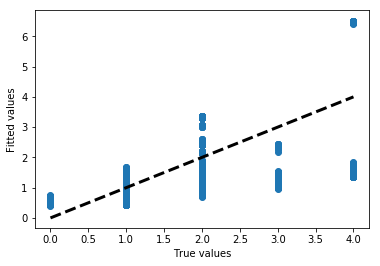

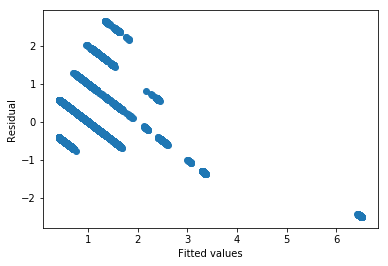

Train set average RMSE:  0.715301090802
Test set average RMSE:  0.715896076233


In [162]:
reportandplot(basicregression, featurematrix, y)

#### ii) Data Preprocessing: with standardized feature data

In [163]:
stand = StandardScaler()
X_stand = stand.fit_transform(np.float64(featurematrix))

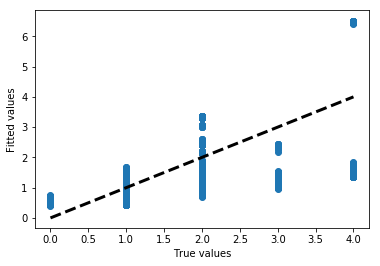

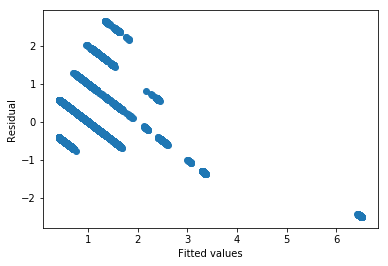

Train set average RMSE:  0.715301090802
Test set average RMSE:  0.715896076233


In [164]:
reportandplot(basicregression, X_stand, y)

#### iii) Feature Selection: select three most important features

In [173]:
from sklearn.feature_selection import SelectKBest, f_regression
best3_f = SelectKBest(f_regression, k=3)
X_best3_f = best3_f.fit_transform(featurematrix, y)
print("best 3 for f_regression: " + str(best3_f.get_support()))

best 3 for f_regression: [False  True  True False False  True]


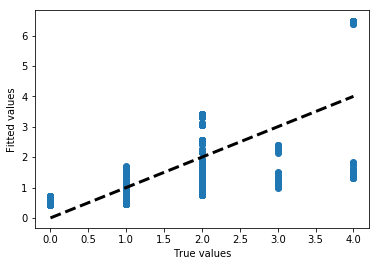

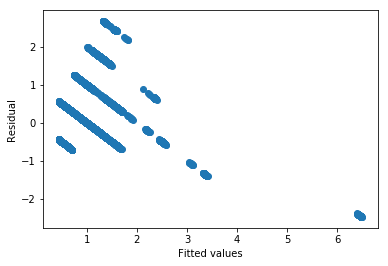

Train set average RMSE:  0.715301090802
Test set average RMSE:  0.715896076233


In [175]:
reportandplot(basicregression, X_best3_f, y)

In [174]:
from sklearn.feature_selection import mutual_info_regression
best3_m = SelectKBest(mutual_info_regression, k=3)
X_best3_m = best3_m.fit_transform(featurematrix, y)
print("best 3 for mutual_info_regression: " + str(best3_m.get_support()))

best 3 for mutual_info_regression: [False False False  True  True  True]


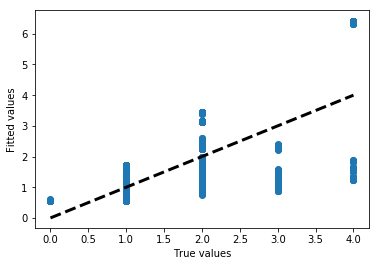

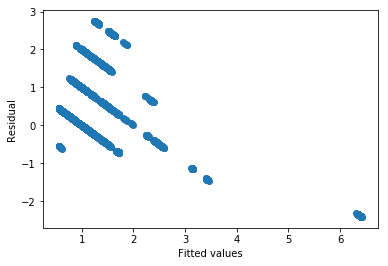

Train set average RMSE:  0.715301090802
Test set average RMSE:  0.715896076233


In [176]:
reportandplot(basicregression, X_best3_m, y)

#### iv) Feature Encoding:

In [179]:
from sklearn.preprocessing import OneHotEncoder
import itertools
tftable = list(itertools.product([False, True], repeat=5))
print(tftable)

'''
avg_training_rmse = []
avg_test_rmse = []
for c, combination in enumerate(table):
    print(str(c) + " " + str(combination))
    enc = OneHotEncoder(categorical_features=combination, sparse=False)
    X_new = enc.fit_transform(featurematrix)

    kf = KFold(10)
    k = 1
    
    training_rmse = []
    test_rmse = []
    for train_index, test_index in kf.split(X_new): # Output 10 train test RMSE values
        X_train, X_test = X_new[train_index], X_new[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lr = linear_model.LinearRegression()
        lr.fit(X_train, y_train)
        pred_train, pred_test = lr.predict(X_train), lr.predict(X_test)

        rmse_train, rmse_test = sqrt(mean_squared_error(y_train, pred_train)), sqrt(mean_squared_error(y_test, pred_test))
        training_rmse.append(rmse_train)
        test_rmse.append(rmse_test)
#        print("Fold %i: train RMSE = %.3f, test RMSE = %.3f" % (k, rmse_train, rmse_test))
        k += 1
#     print(np.mean(training_rmse), np.mean(test_rmse))
    avg_training_rmse.append(np.mean(training_rmse))
    avg_test_rmse.append(np.mean(test_rmse))
    
print(np.argmin(avg_training_rmse), np.argmin(avg_test_rmse))
print(avg_training_rmse[14], avg_test_rmse[15])
'''

[(False, False, False, False, False), (False, False, False, False, True), (False, False, False, True, False), (False, False, False, True, True), (False, False, True, False, False), (False, False, True, False, True), (False, False, True, True, False), (False, False, True, True, True), (False, True, False, False, False), (False, True, False, False, True), (False, True, False, True, False), (False, True, False, True, True), (False, True, True, False, False), (False, True, True, False, True), (False, True, True, True, False), (False, True, True, True, True), (True, False, False, False, False), (True, False, False, False, True), (True, False, False, True, False), (True, False, False, True, True), (True, False, True, False, False), (True, False, True, False, True), (True, False, True, True, False), (True, False, True, True, True), (True, True, False, False, False), (True, True, False, False, True), (True, True, False, True, False), (True, True, False, True, True), (True, True, True, False, F

'\navg_training_rmse = []\navg_test_rmse = []\nfor c, combination in enumerate(table):\n    print(str(c) + " " + str(combination))\n    enc = OneHotEncoder(categorical_features=combination, sparse=False)\n    X_new = enc.fit_transform(featurematrix)\n\n    kf = KFold(10)\n    k = 1\n    \n    training_rmse = []\n    test_rmse = []\n    for train_index, test_index in kf.split(X_new): # Output 10 train test RMSE values\n        X_train, X_test = X_new[train_index], X_new[test_index]\n        y_train, y_test = y[train_index], y[test_index]\n        lr = linear_model.LinearRegression()\n        lr.fit(X_train, y_train)\n        pred_train, pred_test = lr.predict(X_train), lr.predict(X_test)\n\n        rmse_train, rmse_test = sqrt(mean_squared_error(y_train, pred_train)), sqrt(mean_squared_error(y_test, pred_test))\n        training_rmse.append(rmse_train)\n        test_rmse.append(rmse_test)\n#        print("Fold %i: train RMSE = %.3f, test RMSE = %.3f" % (k, rmse_train, rmse_test))\n     

In [51]:
# the comb where no feature is chosen is omitted, so 31 comb in total
import itertools
parta4=LinearRegression()
allcomb=[]
testlist=[]
trainlist=[]
for i in range(1,6):
    listi=list(itertools.combinations(range(5),i))
    for item in listi:
        allcomb.append(item)
        arraypos=np.asarray(item)
        desirefeat=featurematrix[:,arraypos]
        #print (desirefeat.shape)
        results=cross_validate(parta4, desirefeat, y, scoring='neg_mean_squared_error', cv=10, return_train_score=True)
        testlist.append(np.mean(results['test_score']))
        trainlist.append(np.mean(results['train_score']))

print ('best comb is :',allcomb[np.argsort(testlist)[-1]])
print ('day_of_week,hour_of_day')

best comb is : (1, 2)
day_of_week,hour_of_day


### part a v

overfitting 

In [54]:
testlist[9]

-0.010746895474743634

In [64]:
[10**num for num in range(-3,4)]

[0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [87]:
def findbestcomb (clf,X,y):
    allcomb=[]
    testlist=[]
    trainlist=[]
    for i in range(1,6):
        listi=list(itertools.combinations(range(5),i))
        for item in listi:
            allcomb.append(item)
            arraypos=np.asarray(item)
            desirefeat=X[:,arraypos]
            #print (desirefeat.shape)
            results=cross_validate(clf, desirefeat, y, scoring='neg_mean_squared_error', cv=10, return_train_score=True)
            testlist.append(np.mean(results['test_score']))
            trainlist.append(np.mean(results['train_score']))
    return allcomb[np.argsort(testlist)[-1]],-max(testlist)

In [88]:
findbestcomb(parta4,featurematrix,y)

((1, 2), 0.010746895474743634)

In [114]:
from sklearn.linear_model import Ridge
errorlist=[]
comblist=[]
for a in [10**num for num in range(-7,8)]:
    parta5=Ridge(alpha=a)
    comb, error=findbestcomb(parta5,featurematrix,y)
    print (comb, error)
    comblist.append(comb)
    errorlist.append(error)

(1, 2) 0.0107468954747
(1, 2) 0.0107468954747
(1, 2) 0.0107468954747
(1, 2) 0.0107468954747
(1, 2) 0.0107468954747
(1, 2) 0.0107468954745
(1, 2) 0.010746895472
(1, 2) 0.010746895447
(1, 2) 0.0107468951975
(1, 2) 0.0107468927553
(1, 2) 0.0107468734171
(1, 2, 3) 0.0107449365001
(1, 2, 3) 0.0107526186499
(1, 2, 4) 0.0107893910019
(1, 2, 3, 4) 0.0108415172306


In [115]:
comblist[np.argsort(errorlist)[0]]

(1, 2, 3)

In [116]:
errorlist[np.argsort(errorlist)[0]]

0.010744936500136325

In [117]:
from sklearn.linear_model import Lasso
errorlist=[]
comblist=[]
for a in [10**num for num in range(-7,8)]:
    parta5=Lasso(alpha=a)
    comb, error=findbestcomb(parta5,featurematrix,y)
    print (comb, error)
    comblist.append(comb)
    errorlist.append(error)

(1, 2) 0.0107468954636
(1, 2) 0.0107468953636
(1, 2) 0.0107468943879
(1, 2) 0.0107468871096
(1, 2) 0.0107470621587
(0, 1, 2) 0.0107707940766
(0, 1, 2, 3, 4) 0.0108556056707
(0, 1, 2, 3, 4) 0.0108556056707
(0, 1, 2, 3, 4) 0.0108556056707
(0, 1, 2, 3, 4) 0.0108556056707
(0, 1, 2, 3, 4) 0.0108556056707
(0, 1, 2, 3, 4) 0.0108556056707
(0, 1, 2, 3, 4) 0.0108556056707
(0, 1, 2, 3, 4) 0.0108556056707
(0, 1, 2, 3, 4) 0.0108556056707


In [118]:
comblist[np.argsort(errorlist)[0]]

(1, 2)

In [119]:
errorlist[np.argsort(errorlist)[0]]

0.010746887109607048